In [5]:
#Logistic regression with the help of kaggle notebooks (https://www.kaggle.com/bphlmn/simple-logistic-regression)

#Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#Import both test and train sets and concatinate them for data cleaning and feature engineering

df_train = pd.read_csv("D:\\Datasets\\Titanic Machine Learning from Disaster\\kaggle datasets\\train.csv")
df_test = pd.read_csv("D:\\Datasets\\Titanic Machine Learning from Disaster\\kaggle datasets\\test.csv")

df_full = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [7]:
##################################################################################################################################################################################################################
##### Exploratory analysis #######################################################################################################################################################################################
##################################################################################################################################################################################################################

df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


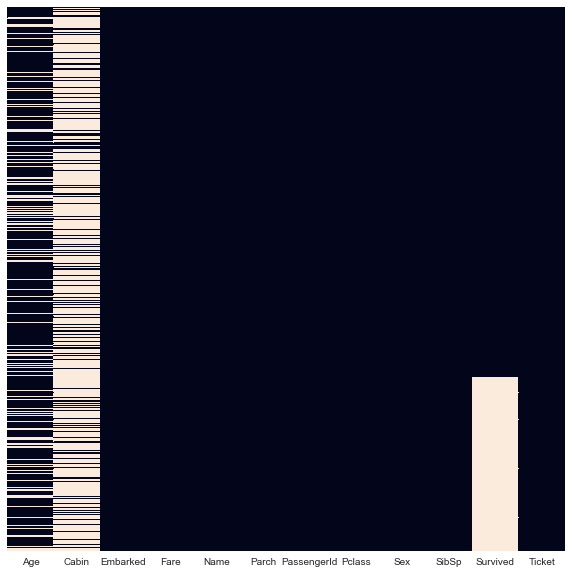

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(df_full.isnull(), yticklabels=False, cbar=False)

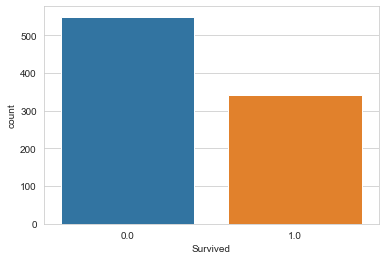

In [11]:
sns.set_style("whitegrid")
sns.countplot(x='Survived', data=df_full)

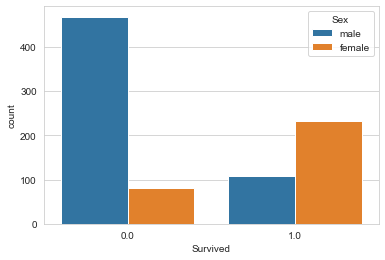

In [13]:
sns.countplot(x='Survived', hue='Sex', data=df_full)

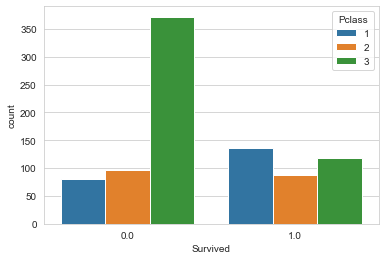

In [15]:
sns.countplot(x='Survived', hue='Pclass', data=df_full)

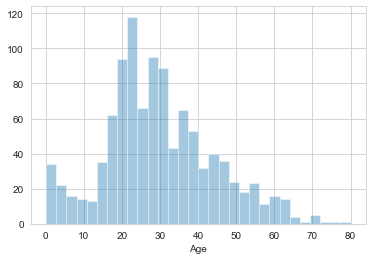

In [17]:
sns.distplot(df_full['Age'].dropna(), kde=False, bins = 30)

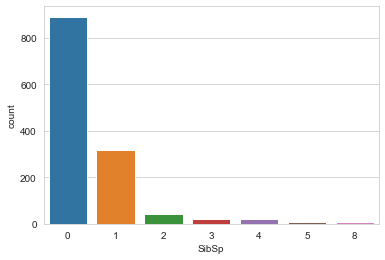

In [19]:
sns.countplot(x='SibSp', data=df_full)

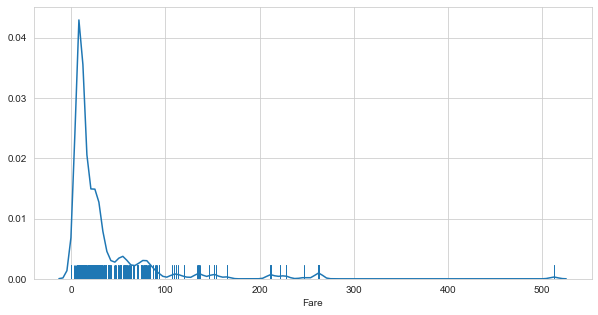

In [21]:
plt.figure(figsize=(10,5))
sns.distplot(df_full['Fare'].dropna(), rug=True, hist=False)

In [23]:


##################################################################################################################################################################################################################
##### Cleaning and imputation ####################################################################################################################################################################################
##################################################################################################################################################################################################################


#Average age per social class
df_full.groupby('Pclass').mean()['Age']


Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64

In [25]:
#Put in the average age for each class

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        
        if Pclass == 1:
            return 39.159930
        elif Pclass == 2:
            return 29.506705
        else:
            return 24.816367
    
    else:
        return Age

#Apply the function
df_full["Age"] = df_full[["Age","Pclass"]].apply(impute_age, axis=1)

In [27]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


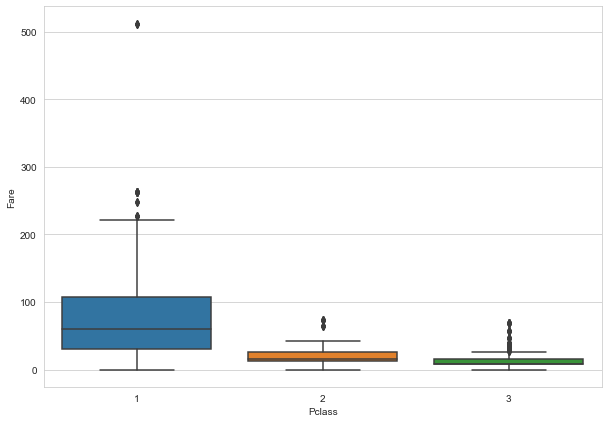

In [29]:
# We have two missing values in Embarked and one in Fare. We can fill in the missing fare by looking how it relates to Passenger Class.
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass', y='Fare', data=df_full)

In [31]:
df_full.groupby("Pclass").mean()["Fare"]

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

In [33]:
df_full[df_full["Fare"].isnull()]

Empty DataFrame
Columns: [Age, Cabin, Embarked, Fare, Name, Parch, PassengerId, Pclass, Sex, SibSp, Survived, Ticket]
Index: []

In [35]:
#Since Mr. Thomas Storey is a 3rd class passenger, let's assign the average fare of $13.30.

df_full.loc[df_full["PassengerId"] == 1044 , 'Fare'] = 13.3028
df_full[df_full["PassengerId"] == 1044]

Age Cabin Embarked     Fare                Name  Parch  PassengerId  \
1043  60.5   NaN        S  13.3028  Storey, Mr. Thomas      0         1044   

      Pclass   Sex  SibSp  Survived Ticket  
1043       3  male      0       NaN   3701

In [37]:
df_full[df_full["Embarked"].isnull()]

Empty DataFrame
Columns: [Age, Cabin, Embarked, Fare, Name, Parch, PassengerId, Pclass, Sex, SibSp, Survived, Ticket]
Index: []

In [39]:
#Following the imputation analysis here, it appears they departed from Charbourg.
#https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic

df_full.loc[df_full["PassengerId"].isin([62, 830]), "Embarked"] = "C"
df_full.loc[df_full["PassengerId"].isin([62,830])]

Age Embarked  Fare                                       Name  Parch  \
61   38.0        C  80.0                        Icard, Miss. Amelie      0   
829  62.0        C  80.0  Stone, Mrs. George Nelson (Martha Evelyn)      0   

     PassengerId  Pclass     Sex  SibSp  Survived  
61            62       1  female      0       1.0  
829          830       1  female      0       1.0

In [41]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
Age            1309 non-null float64
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
dtypes: float64(3), int64(4), object(3)
memory usage: 102.4+ KB


In [43]:
#We will deem Cabin a lost cause at this point and we won't investigate the Ticket column, so let's drop those here.

df_full.drop(['Cabin', 'Ticket'], axis=1, inplace=True)


KeyError: "['Cabin' 'Ticket'] not found in axis"

In [45]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
Age            1309 non-null float64
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
dtypes: float64(3), int64(4), object(3)
memory usage: 102.4+ KB


In [46]:

##################################################################################################################################################################################################################
##### Feature engineering ########################################################################################################################################################################################
##################################################################################################################################################################################################################

# We need to create a dummy variable to turn Sex and Embarked into 0s and 1s.

sex = pd.get_dummies(df_full["Sex"], drop_first=True)
sex.head()

male
0     1
1     0
2     0
3     0
4     1

In [47]:
embark = pd.get_dummies(df_full['Embarked'], drop_first=True)
embark.head()

Q  S
0  0  1
1  0  0
2  0  1
3  0  1
4  0  1

In [58]:
#Concate the new dummy variables onto the full dataset

#df_full = pd.concat([df_full, sex, embark], axis=1)
#df_full.drop(['Sex', 'Embarked'], axis=1, inplace=True)
df_full.head()

Age     Fare  Parch  Pclass  SibSp  Survived  male  Q  S
0  22.0   7.2500      0       3      1       0.0     1  0  1
1  38.0  71.2833      0       1      1       1.0     0  0  0
2  26.0   7.9250      0       3      0       1.0     0  0  1
3  35.0  53.1000      0       1      1       1.0     0  0  1
4  35.0   8.0500      0       3      0       0.0     1  0  1

In [59]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
Age         1309 non-null float64
Fare        1309 non-null float64
Parch       1309 non-null int64
Pclass      1309 non-null int64
SibSp       1309 non-null int64
Survived    891 non-null float64
male        1309 non-null uint8
Q           1309 non-null uint8
S           1309 non-null uint8
dtypes: float64(3), int64(3), uint8(3)
memory usage: 65.3 KB


In [60]:
#Drop passenger ID and Name

df_full.drop(['PassengerId', 'Name'], axis=1, inplace=True)

KeyError: "['PassengerId' 'Name'] not found in axis"

In [61]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
Age         1309 non-null float64
Fare        1309 non-null float64
Parch       1309 non-null int64
Pclass      1309 non-null int64
SibSp       1309 non-null int64
Survived    891 non-null float64
male        1309 non-null uint8
Q           1309 non-null uint8
S           1309 non-null uint8
dtypes: float64(3), int64(3), uint8(3)
memory usage: 65.3 KB


In [52]:
##################################################################################################################################################################################################################
##### Building the logistic regression model #####################################################################################################################################################################
##################################################################################################################################################################################################################

# In stratified k-fold cross-validation, the partitions are selected so that the mean response value is approximately equal in all the partitions. In the case of binary classification, this means that each partition contains roughly the same proportions of the two types of class labels.

df_train = df_full[:891]
df_test = df_full[891:]

In [53]:
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

Age     Fare  Parch  Pclass  SibSp  male  Q  S
0    22.000000   7.2500      0       3      1     1  0  1
1    38.000000  71.2833      0       1      1     0  0  0
2    26.000000   7.9250      0       3      0     0  0  1
3    35.000000  53.1000      0       1      1     0  0  1
4    35.000000   8.0500      0       3      0     1  0  1
..         ...      ...    ...     ...    ...   ... .. ..
886  27.000000  13.0000      0       2      0     1  0  1
887  19.000000  30.0000      0       1      0     0  0  1
888  24.816367  23.4500      2       3      1     0  0  1
889  26.000000  30.0000      0       1      0     1  0  0
890  32.000000   7.7500      0       3      0     1  1  0

[891 rows x 8 columns]

In [54]:
skf = StratifiedKFold(n_splits=3,  shuffle=False, random_state=1)
skf.get_n_splits(X,y)

3

In [55]:
print(skf)

StratifiedKFold(n_splits=3, random_state=1, shuffle=False)


In [56]:

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html


for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    logmodel = LogisticRegression()
    logmodel.fit(X_train, y_train)
    predictions = logmodel.predict(X_test)
    print("\nModel score: " + str(logmodel.score(X_test, y_test)))
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))

ValueError: could not convert string to float: 'male'